### loading necessary libraries

In [1]:
import tensorflow as tf
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings("ignore")


2024-03-31 13:55:15.415378: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
for dirpath, dirnames, filenames in os.walk("/home/archie/Music/ml2/FaceExpressions/dataset"):
  print(f"There are {len(filenames)} images in '{dirpath}'.")

There are 0 images in '/home/archie/Music/ml2/FaceExpressions/dataset'.
There are 1313 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Angry'.
There are 1234 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Surprise'.
There are 3740 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Happy'.
There are 4027 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Neutral'.
There are 3934 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Sad'.
There are 1205 images in '/home/archie/Music/ml2/FaceExpressions/dataset/Ahegao'.


## visualizing the images

In [3]:
def view_random_images(target_class, num_images=8):
  target_dir="/home/archie/Music/ml2/FaceExpressions/dataset"
  target_folder = os.path.join(target_dir, target_class)

  random_images = random.sample(os.listdir(target_folder), num_images)

  # Create a subplot to display multiple images
  plt.figure(figsize=(12, 6))
  for i, image in enumerate(random_images):
    plt.subplot(2, 4, i + 1)  # 2 rows, 4 columns
    img = mpimg.imread(os.path.join(target_folder, image))
    plt.imshow(img)
    plt.title(f"{target_class} - {i + 1}")
    plt.axis("off")

  plt.show()

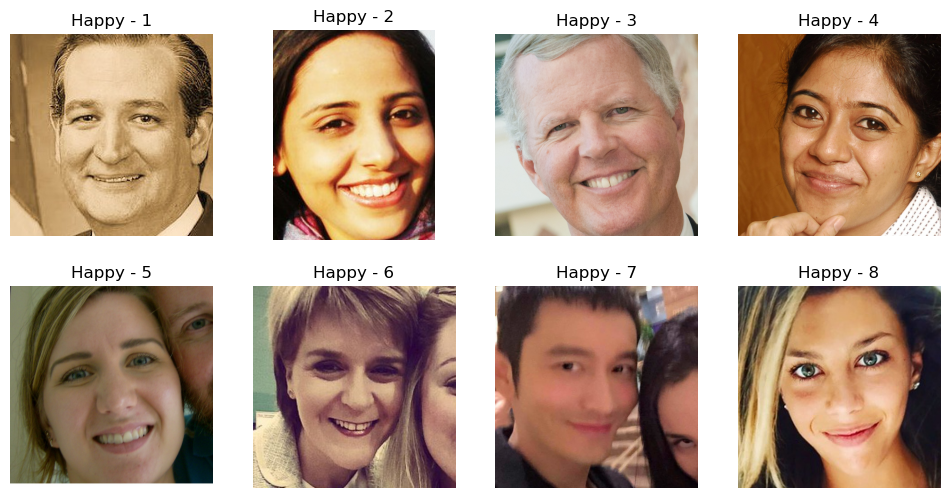

In [5]:
view_random_images("Happy",8)

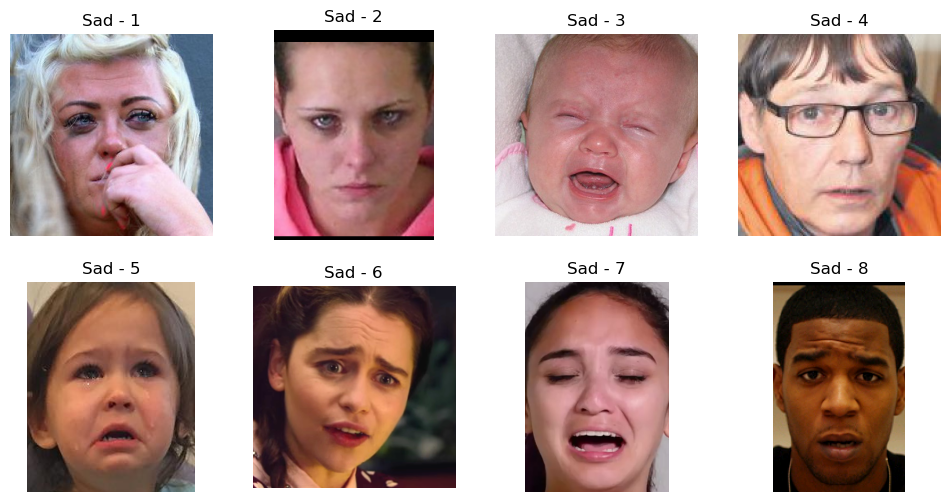

In [6]:
view_random_images("Sad",8)

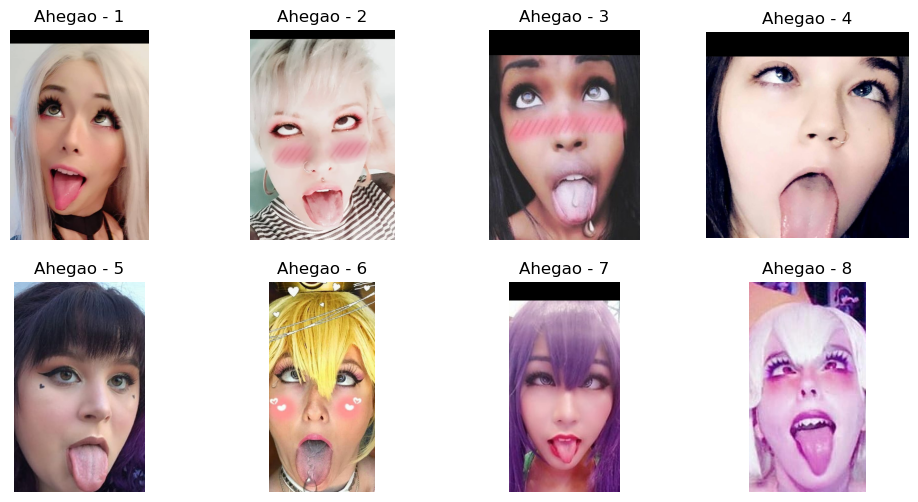

In [7]:
view_random_images("Ahegao",8)
#😐😐

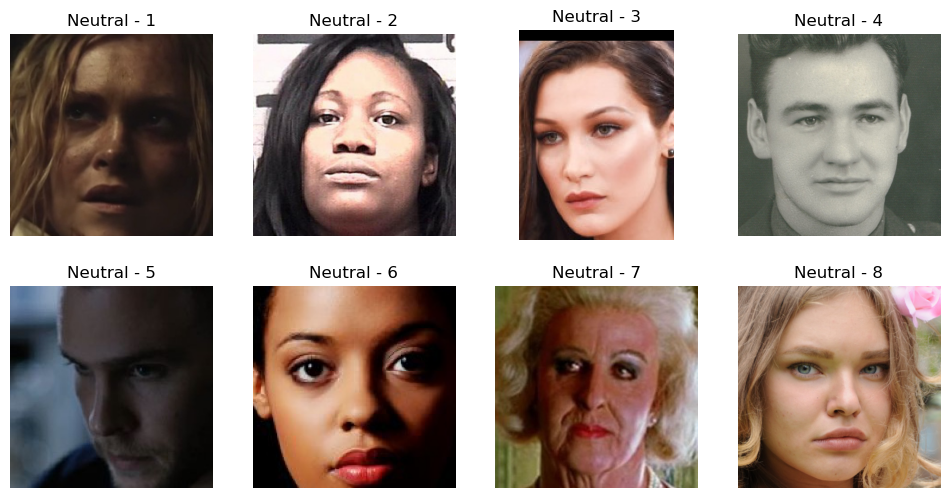

In [8]:
view_random_images("Neutral",8)

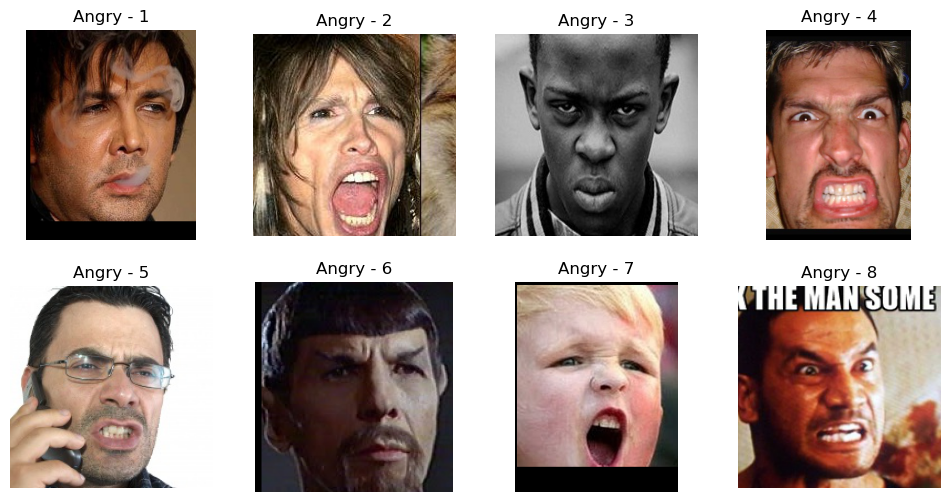

In [9]:
view_random_images("Angry",8)

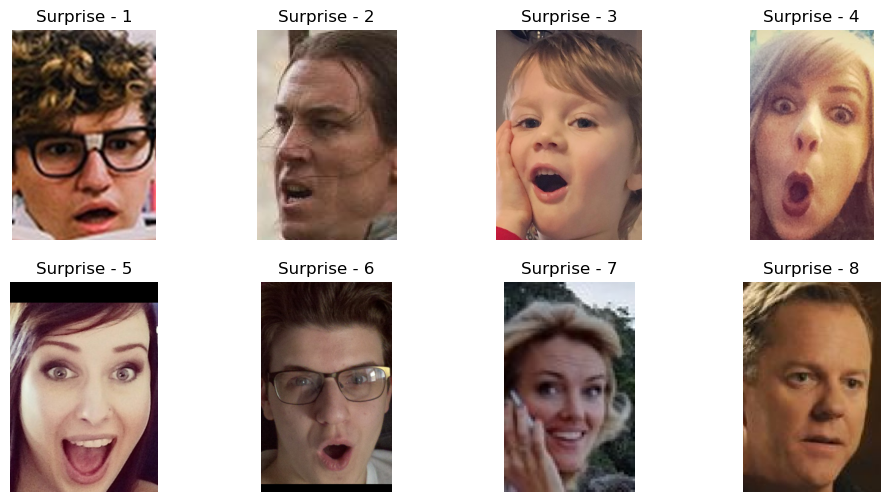

In [10]:
view_random_images("Surprise",8)

### Data preprocessing

In [11]:
data_dir='/home/archie/Music/ml2/FaceExpressions/dataset'
IMG_SIZE = (224, 224) # define image size
total_data= tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=32)


Found 15453 files belonging to 6 classes.


2024-03-31 13:58:40.268387: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [12]:
total_samples = total_data.cardinality().numpy()

train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Split the dataset
train_data = total_data.take(train_size)
test_data = total_data.skip(train_size)

print("Number of samples in training set:", train_size)
print("Number of samples in testing set:", test_size)

Number of samples in training set: 386
Number of samples in testing set: 97


In [13]:
total_data.class_names

['Ahegao', 'Angry', 'Happy', 'Neutral', 'Sad', 'Surprise']

### Creating Callbacks
* Tensorbord callback


In [10]:
checkpoint_path="Expresion/checkpoint.ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [11]:
import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creatin a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

# Mixed_precision
* speedup the training upto 3x
* one change we have to do is that in output layer we have to add dtype='float32'

In [12]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### Data augmentaion sequencial layer

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # remove for EfficientNetB0
], name ="data_augmentation")

### First Model

In [14]:
from tensorflow import keras
from tensorflow.keras import layers

In [15]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB7(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation Sequential model as a layer
#x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(inputs, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Put a dense layer on as the output
outputs = layers.Dense(6, activation="softmax",dtype='float32', name="output_layer")(x)
#dtype='float32' because we are using mixpresion

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

258076736/258076736 [==============================] - 6s 0us/step


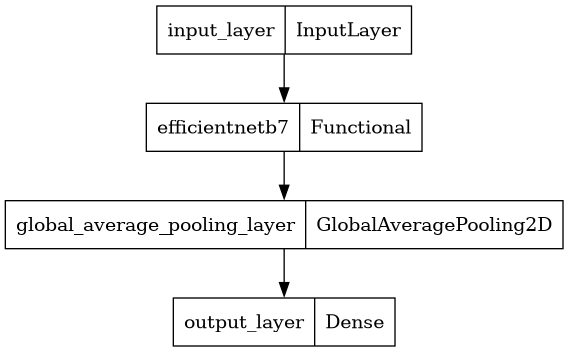

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(model_1)


I tried but Augmentation Layer do not increse accuracy despite it decrease in my case,so i removed it

In [17]:
#complile the model
model_1.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb7 (Functional  (None, None, None, 2560   64097687  
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 2560)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 6)                 15366     
                                                                 
Total params: 64113053 (244.57 MB)
Trainable params: 15366 (60.02 KB)
Non-trainable params: 64097687 (244.51 MB)
______________

In [18]:
history_model_1_efficientB7 = model_1.fit(train_data,
                                           steps_per_epoch=len(train_data),
                                           epochs=10,
                                           batch_size=32,
                                           validation_data=test_data,
                                           validation_steps=len(test_data),
                                           callbacks=[checkpoint_callback] #out of memory page error happening after 4 to 5 epoch
                                       )


Epoch 1/10
386/386 [==============================] - ETA: 0s - loss: 1.0474 - accuracy: 0.5924
Epoch 1: val_loss improved from inf to 0.91243, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 382s 926ms/step - loss: 1.0474 - accuracy: 0.5924 - val_loss: 0.9124 - val_accuracy: 0.6520
Epoch 2/10
386/386 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.6618
Epoch 2: val_loss improved from 0.91243 to 0.85923, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 121s 311ms/step - loss: 0.8687 - accuracy: 0.6618 - val_loss: 0.8592 - val_accuracy: 0.6678
Epoch 3/10
386/386 [==============================] - ETA: 0s - loss: 0.8100 - accuracy: 0.6862
Epoch 3: val_loss improved from 0.85923 to 0.83798, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 121s 312ms/step - loss: 0.8100 - accuracy: 0.6862 - val_loss: 0.8380 - val_accuracy: 0.6743
Epoch 4/10
386/386 [=========

In [19]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
    
  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

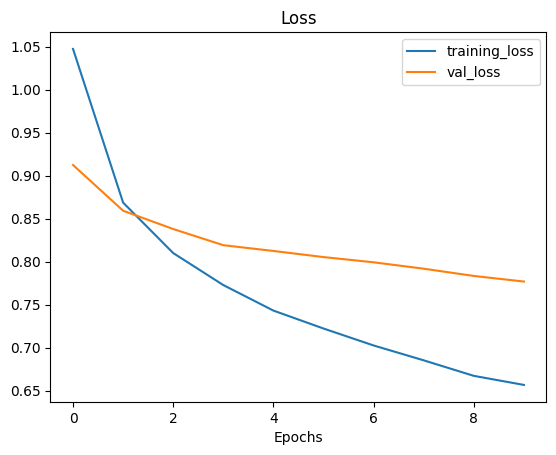

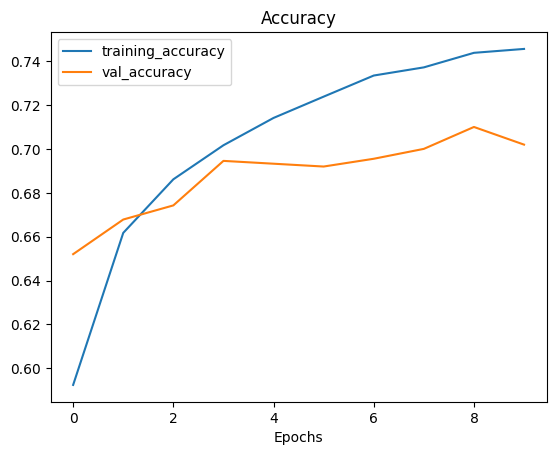

In [20]:
plot_loss_curves(history_model_1_efficientB7)

97/97 [==============================] - 44s 181ms/step


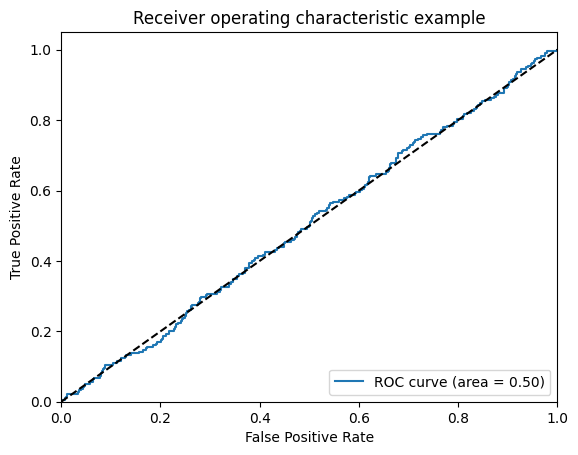

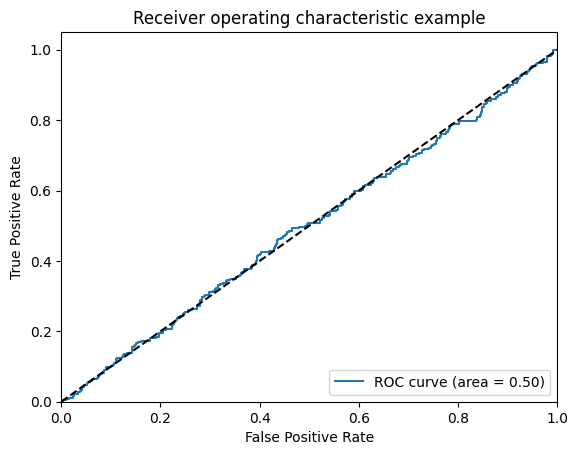

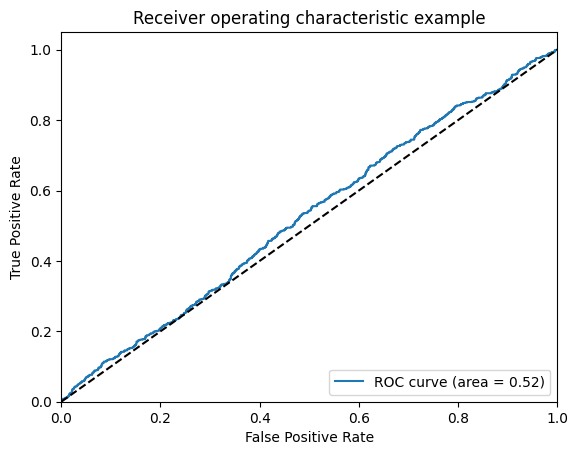

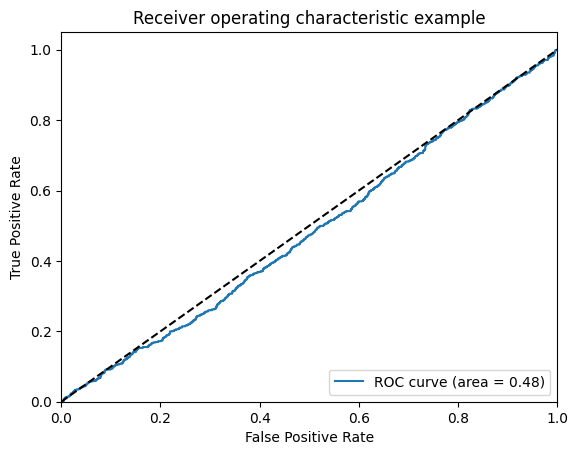

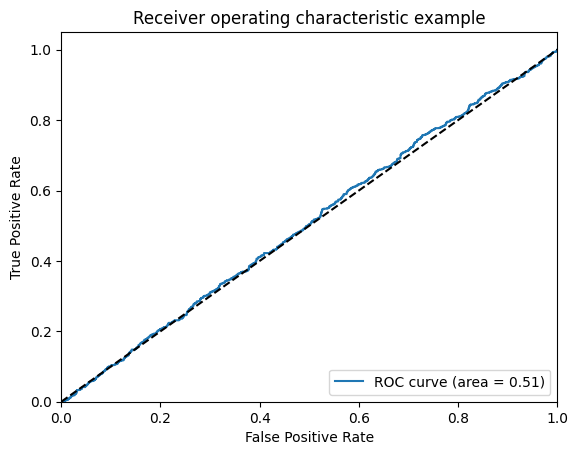

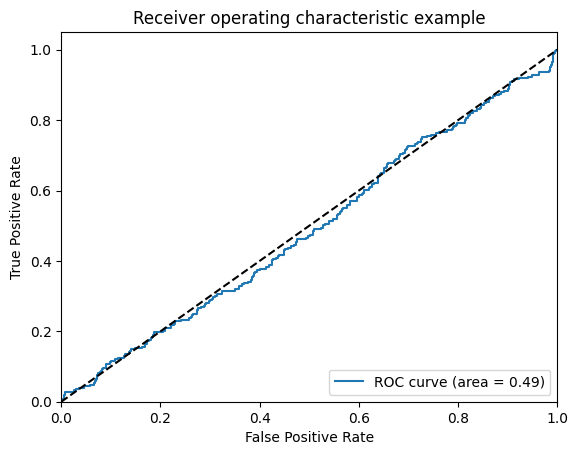

In [52]:
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

# Assuming your model is named 'model_1' and your test dataset is 'test_data'
# First, get the true labels and predictions
y_true = np.concatenate([y for x, y in test_data], axis=0)
y_pred = model_1.predict(test_data)

# Since your labels are one-hot encoded, you need to find the indices for the true labels
y_true = np.argmax(y_true, axis=1)

# Calculate ROC curve and ROC area for each class
n_classes = 6 # Number of classes
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=n_classes)[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()


# Lets fine tune our model by unfreezing some of the layer 

In [22]:
model_1.load_weights(checkpoint_path)

In [23]:
model_1.evaluate(test_data)

97/97 [==============================] - 45s 186ms/step - loss: 0.7860 - accuracy: 0.6988


[0.7860016226768494, 0.6988068222999573]

In [24]:
# Are these layers trainable?
for layer in model_1.layers:
  print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x78adbcf852d0> True
<keras.src.engine.functional.Functional object at 0x78ada4e08b20> False
<keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x78ae4aafca90> True
<keras.src.layers.core.dense.Dense object at 0x78ae7ba96350> True


In [26]:
# Access the base_model layers of model_1
model_1_base_model = model_1.layers[1]
model_1_base_model.name

'efficientnetb7'

In [27]:
# Make all the layers in model_1_base_model trainable
model_1_base_model.trainable = True

# Freeze all layers except for the last 15
for layer in model_1_base_model.layers[:-15]:
  layer.trainable = False

# Recompile (we have to recompile our models every time we make a change)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning you typically want to lower the learning rate by 10x*
                metrics=["accuracy"])
print(len(model_1.trainable_variables))

15


In [28]:
# Fine-tune for another 10 epochs
initial_epoch=10
fine_tune_epochs = initial_epoch + 5

# Refit the model (same as model_1 except with more trainable layers)
history_model_1_efficientB7_fineTune = model_1.fit(train_data,
                                                steps_per_epoch=len(train_data),
                                                epochs=fine_tune_epochs,
                                                batch_size=32,
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                initial_epoch=history_model_1_efficientB7.epoch[-1],# start from the previous last epoch
                                                callbacks=[checkpoint_callback]
                                                           )

Epoch 10/15
386/386 [==============================] - ETA: 0s - loss: 0.6522 - accuracy: 0.7461
Epoch 10: val_loss improved from 0.77691 to 0.73918, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 154s 331ms/step - loss: 0.6522 - accuracy: 0.7461 - val_loss: 0.7392 - val_accuracy: 0.7140
Epoch 11/15
386/386 [==============================] - ETA: 0s - loss: 0.5376 - accuracy: 0.7921
Epoch 11: val_loss improved from 0.73918 to 0.71505, saving model to Expresion/checkpoint.ckpt
386/386 [==============================] - 123s 318ms/step - loss: 0.5376 - accuracy: 0.7921 - val_loss: 0.7150 - val_accuracy: 0.7288
Epoch 12/15
386/386 [==============================] - ETA: 0s - loss: 0.4486 - accuracy: 0.8335
Epoch 12: val_loss did not improve from 0.71505
386/386 [==============================] - 121s 312ms/step - loss: 0.4486 - accuracy: 0.8335 - val_loss: 0.7378 - val_accuracy: 0.7169
Epoch 13/15
386/386 [==============================] - ETA: 0s - l

In [30]:
model_1.load_weights(checkpoint_path)

In [31]:
model_1.evaluate(test_data)

97/97 [==============================] - 46s 190ms/step - loss: 0.7168 - accuracy: 0.7275


[0.7168375849723816, 0.7275072336196899]

### fine tuning

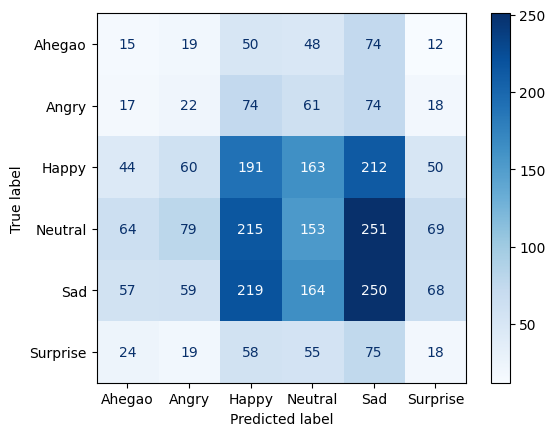

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Assuming y_true contains the true labels and y_pred contains the predicted probabilities
y_pred_labels = np.argmax(y_pred, axis=1)  # Convert probabilities to predicted labels

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=total_data.class_names)

# Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues)
plt.show()


In [33]:
from sklearn.metrics import roc_auc_score

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(to_categorical(y_true, num_classes=n_classes), y_pred, multi_class='ovr')

print(f"Average ROC-AUC score: {roc_auc:.2f}")


Average ROC-AUC score: 0.51


In [34]:
checkpoint_path="BigModel/checkpoint.ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                          save_weights_only=True,
                                                          save_best_only=True,
                                                          save_freq="epoch",
                                                          verbose=1)

In [35]:
base_model=tf.keras.applications.efficientnet_v2.EfficientNetV2L(include_top=False)
                                              
base_model.trainable=False

input=tf.keras.layers.Input(shape=(224,224,3),name="inpute_layer")
#(you dont have to do for efficientnet because efficientnet have rescaling build in )
#x=tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)

#5. Pass the inputs to the base model
x=base_model(input)
#6. Average Pool the outputs of the base model(aggregate all the most important information,reduce number of computations)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_avrage_pooling")(x)
#7. Create the inpute with the activation layer
outputs=tf.keras.layers.Dense(6,activation="softmax",dtype='float32',name="Output_layer")(x)

#8. Combine the inpute with output in mode
model_2=tf.keras.Model(input,outputs)

473176280/473176280 [==============================] - 12s 0us/step


In [36]:
#complile the model
model_2.compile(loss=tf.keras.losses.categorical_crossentropy,
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                metrics=['accuracy'])
model_2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inpute_layer (InputLayer)   [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-l (Function  (None, None, None, 1280   117746848 
 al)                         )                                   
                                                                 
 global_avrage_pooling (Glo  (None, 1280)              0         
 balAveragePooling2D)                                            
                                                                 
 Output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 117754534 (449.20 MB)
Trainable params: 7686 (30.02 KB)
Non-trainable params: 117746848 (449.17 MB)
_________________________________________________________________


In [37]:
history_model_2= model_2.fit(train_data,
                            steps_per_epoch=len(train_data),
                            epochs=10,
                            batch_size=32,
                            validation_data=test_data,
                            validation_steps=len(test_data),
                            callbacks=[checkpoint_callback]
                              )
                            

Epoch 1/10
386/386 [==============================] - ETA: 0s - loss: 1.1502 - accuracy: 0.5589
Epoch 1: val_loss improved from inf to 1.00935, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 153s 315ms/step - loss: 1.1502 - accuracy: 0.5589 - val_loss: 1.0093 - val_accuracy: 0.6124
Epoch 2/10
386/386 [==============================] - ETA: 0s - loss: 0.9743 - accuracy: 0.6214
Epoch 2: val_loss improved from 1.00935 to 0.94321, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 116s 298ms/step - loss: 0.9743 - accuracy: 0.6214 - val_loss: 0.9432 - val_accuracy: 0.6311
Epoch 3/10
386/386 [==============================] - ETA: 0s - loss: 0.9220 - accuracy: 0.6413
Epoch 3: val_loss improved from 0.94321 to 0.91750, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 122s 314ms/step - loss: 0.9220 - accuracy: 0.6413 - val_loss: 0.9175 - val_accuracy: 0.6385
Epoch 4/10
386/386 [============

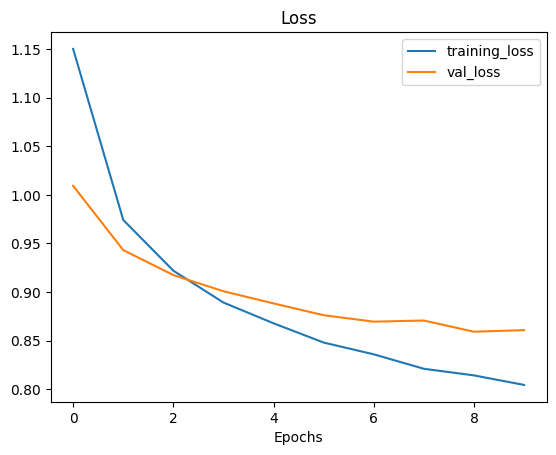

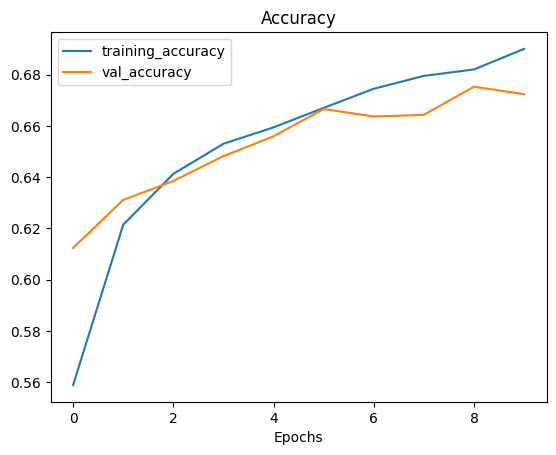

In [38]:
plot_loss_curves(history_model_2)

In [65]:
model_2.load_weights(checkpoint_path)

In [66]:
model_save_path = 'efficient-2.h5'
model_2.save(model_save_path)

from tensorflow.keras.models import load_model

# Load the model
model_loaded2 = load_model('efficient-2.h5')


In [14]:
from tensorflow.keras.models import load_model

# Load the model
model_loaded = load_model('efficient.h5')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


making predictions

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Ahegao/cropped_emotions.40209~ahegao.png
1/1 [==============================] - 19s 19s/step


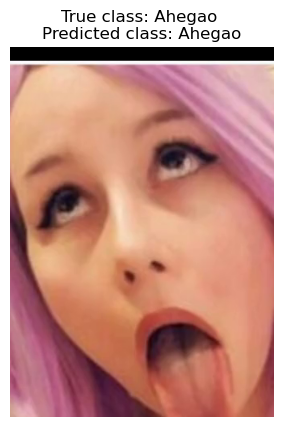

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Ahegao/cropped_emotions.16964~ahegao.png
1/1 [==============================] - 4s 4s/step


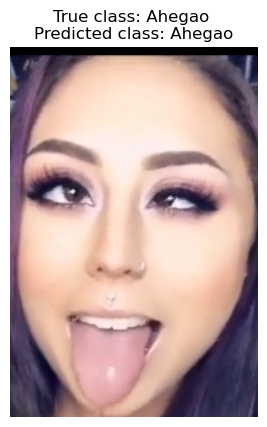

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Ahegao/lol306~ahegao.png
1/1 [==============================] - 5s 5s/step


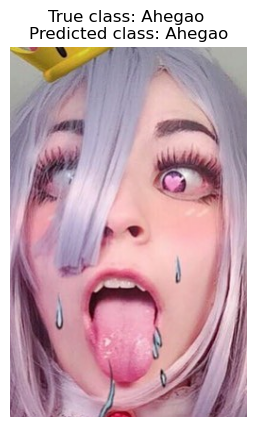

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Angry/cropped_emotions.231788~angry.png
1/1 [==============================] - 4s 4s/step


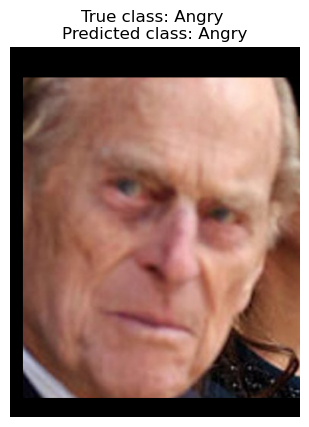

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Angry/967c722cc68bf384b492ebf7d731086a8e1b3ce226323e18fa779c79~angry.jpg
1/1 [==============================] - 4s 4s/step


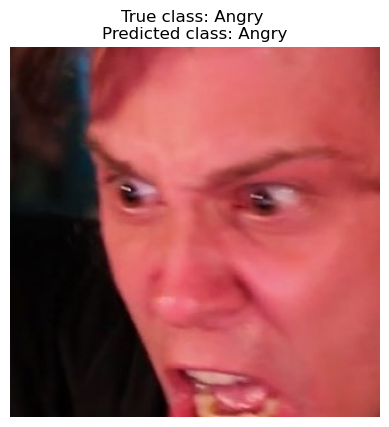

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Angry/39bed989a5c51775d43c85a9cf25a8b64008eb111d3ec386ad12d497~angry.jpg
1/1 [==============================] - 4s 4s/step


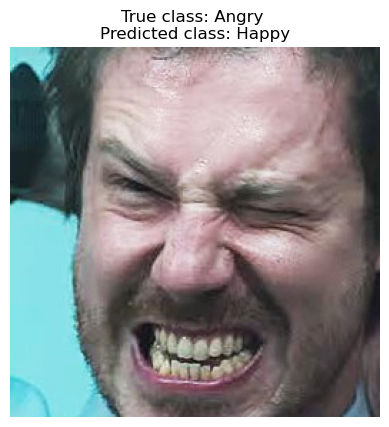

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Happy/0c3502c7d27652cebd469863a9f19ace2ffe6c92656dadd4e7287d65.jpg
1/1 [==============================] - 5s 5s/step


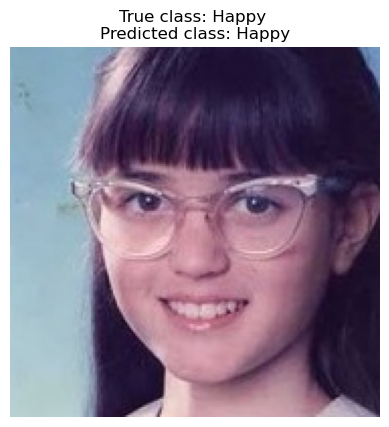

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Happy/cropped_emotions.568851.png
1/1 [==============================] - 4s 4s/step


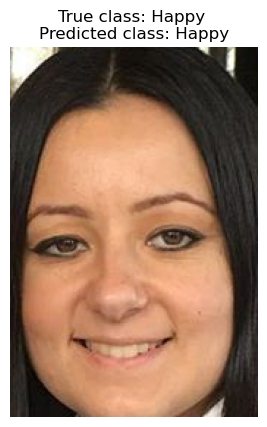

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Happy/2c65a273d56c6f366d7bc5d722b32b500b93675acc5990c9070a0b68.jpg
1/1 [==============================] - 4s 4s/step


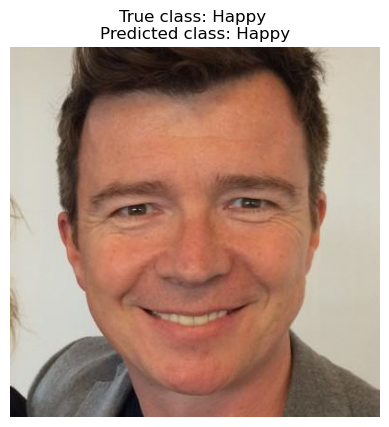

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Neutral/cropped_emotions.452819f.png
1/1 [==============================] - 5s 5s/step


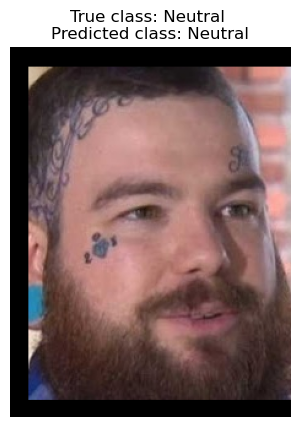

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Neutral/0b668067c6d1e90d81128ce524ddf8064633da6f031507f3f7655115f.jpg
1/1 [==============================] - 5s 5s/step


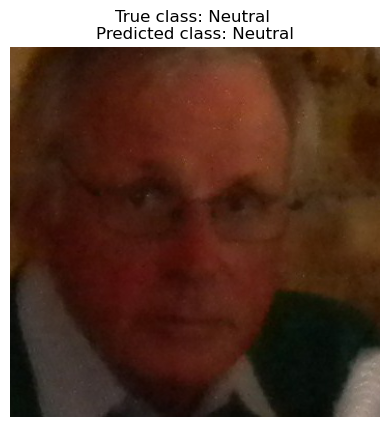

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Neutral/0c74e4d748038277e98ed0edb4283591743c5cc14130b25ebfe3cdf9f.jpg
1/1 [==============================] - 4s 4s/step


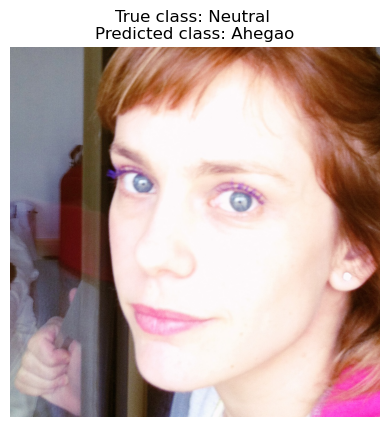

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Sad/5a1449e6afe27d23e1f4b6176c8ce4110d4af58700b4193457117cfb.jpg
1/1 [==============================] - 4s 4s/step


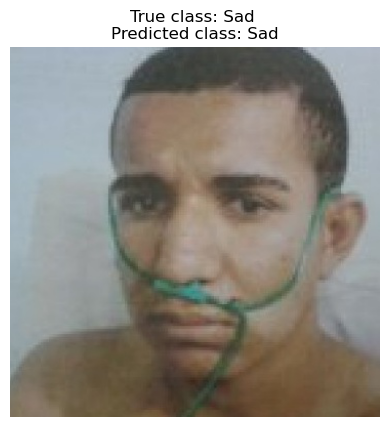

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Sad/cropped_emotions.499100.png
1/1 [==============================] - 4s 4s/step


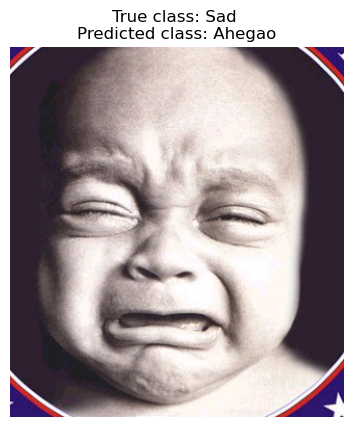

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Sad/2c29b6319a374b0f67aa4d07bdc1a9e6fb7e83eb8f34707376e7479e.jpg
1/1 [==============================] - 4s 4s/step


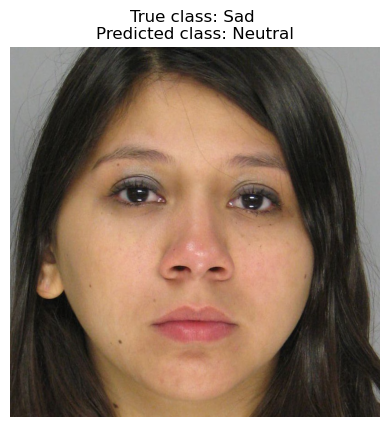

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Surprise/cropped_emotions.261362~12fffff.png
1/1 [==============================] - 4s 4s/step


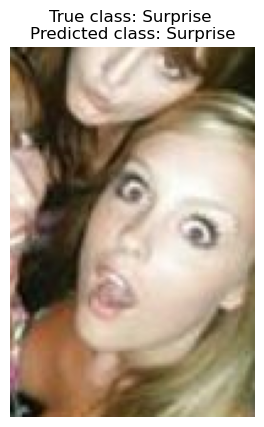

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Surprise/cropped_emotions.260485~12fffff.png
1/1 [==============================] - 4s 4s/step


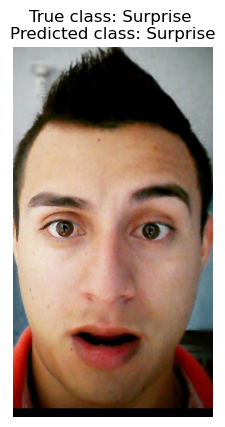

Image path: /home/archie/Music/ml2/FaceExpressions/dataset/Surprise/cropped_emotions.266678~12fffff.png
1/1 [==============================] - 3s 3s/step


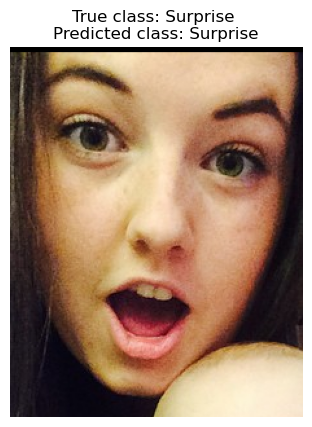

In [15]:
import os
import random
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Base path to your dataset
base_path = '/home/archie/Music/ml2/FaceExpressions/'

# Class names (folders) to match your dataset structure
class_names = ['Ahegao', 'Angry',  'Happy', 'Neutral','Sad', 'Surprise']

# Function to prepare an image
def prepare_image(img_path, img_height=224, img_width=224):
    """Prepares an image for classification by the model."""
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return preprocess_input(img_array_expanded_dims)

# Select 3 random images from each class and predict
for class_name in class_names:
    folder_path = os.path.join(base_path, 'dataset', class_name)
    images = os.listdir(folder_path)
    selected_images = random.sample(images, 3)
    
    for img_name in selected_images:
        img_path = os.path.join(folder_path, img_name)
        
        # Print the path of the current image
        print(f"Image path: {img_path}")
        
        prepared_img = prepare_image(img_path)
        
        # Predict the class
        prediction = model_loaded.predict(prepared_img)
        predicted_class = class_names[np.argmax(prediction)]
        
        # Display the image and prediction
        img = plt.imread(img_path)
        plt.imshow(img)
        plt.title(f"True class: {class_name.capitalize()} \nPredicted class: {predicted_class.capitalize()}")
        plt.axis('off')
        plt.show()


In [82]:
# Access the base_model layers of model_1
model_2_base_model = model_2.layers[1]
model_2_base_model.name

'efficientnetv2-l'

In [83]:
# Make all the layers in model_1_base_model trainable
model_2_base_model.trainable = True

 #Freeze all layers except for the last 15
for layer in model_2_base_model.layers[:-20]:
  layer.trainable = False

# Recompile 
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                metrics=["accuracy"])
print(len(model_2.trainable_variables))

18


In [ ]:
# Fine-tune for another 10 epochs
initial_epoch=10
fine_tune_epochs = initial_epoch + 10

# Refit the model (same as model_1 except with more trainable layers)
history_model_2_fineTune = model_2.fit(train_data,
                                                steps_per_epoch=len(train_data),
                                                epochs=fine_tune_epochs,
                                                batch_size=32,
                                                validation_data=test_data,
                                                validation_steps=len(test_data),
                                                initial_epoch=history_model_2.epoch[-1],# start from the previous last epoch
                                                callbacks=[checkpoint_callback]
                                                           )

Epoch 10/20
386/386 [==============================] - ETA: 0s - loss: 0.7947 - accuracy: 0.6855
Epoch 10: val_loss improved from 0.85921 to 0.73060, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 163s 334ms/step - loss: 0.7947 - accuracy: 0.6855 - val_loss: 0.7306 - val_accuracy: 0.7220
Epoch 11/20
386/386 [==============================] - ETA: 0s - loss: 0.6168 - accuracy: 0.7573
Epoch 11: val_loss improved from 0.73060 to 0.66381, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 119s 308ms/step - loss: 0.6168 - accuracy: 0.7573 - val_loss: 0.6638 - val_accuracy: 0.7404
Epoch 12/20
386/386 [==============================] - ETA: 0s - loss: 0.4980 - accuracy: 0.8081
Epoch 12: val_loss improved from 0.66381 to 0.64282, saving model to BigModel/checkpoint.ckpt
386/386 [==============================] - 120s 309ms/step - loss: 0.4980 - accuracy: 0.8081 - val_loss: 0.6428 - val_accuracy: 0.7559
Epoch 13/20
386/386 [=

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data)